## (peak signal to noise ratio) vs (resolution)
## (bits per pixel) vs (resolution)
## (compression_ratio) vs (resolution)
## [for given window size]

Enter image name that is to be compressed:
lenna256
Enter extention of image that is to be compressed:eg.jpg or.png or .jpeg
.png
image: lenna256.png


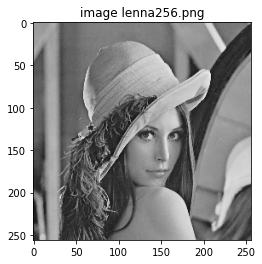

(256, 256)


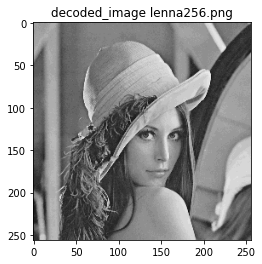

361.20199909921956
[3.9705810546875]
[4.1358871091708425]
Enter image name that is to be compressed:
lenna512
Enter extention of image that is to be compressed:eg.jpg or.png or .jpeg
.jpg
image: lenna512.jpg


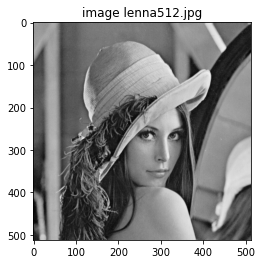

(512, 512)


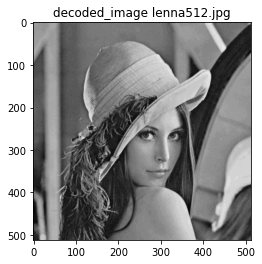

361.20199909921956
[3.9705810546875, 3.95489501953125]
[4.1358871091708425, 3.08755034955322]
Enter image name that is to be compressed:
lenna1024
Enter extention of image that is to be compressed:eg.jpg or.png or .jpeg
.jpg
image: lenna1024.jpg


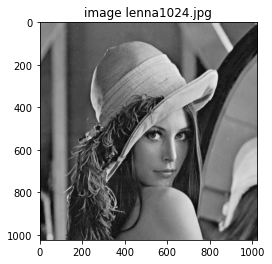

(1024, 1024)


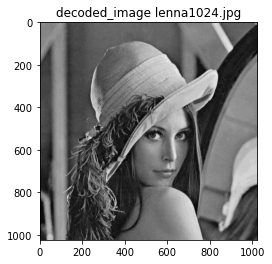

361.20199909921956
[3.9705810546875, 3.95489501953125, 3.9403076171875]
[4.1358871091708425, 3.08755034955322, 2.5646395489327425]
	bits_per_pixel comparision:



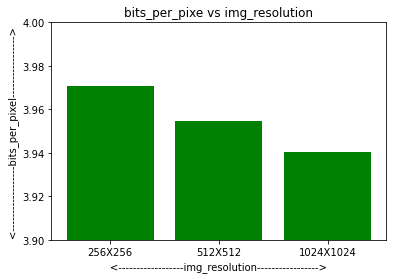

[4.1358871091708425, 3.08755034955322, 2.5646395489327425]
	compression_ratio comparision:



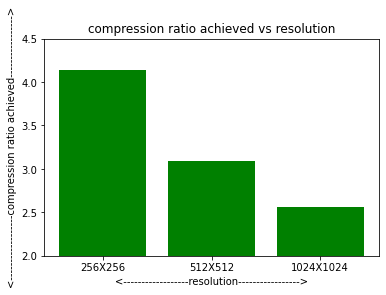

	PSNR_ratio comparision:



<ipython-input-7-a090e7b4aa71>:275: UserWarning: Attempting to set identical bottom == top == 362 results in singular transformations; automatically expanding.
  plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])


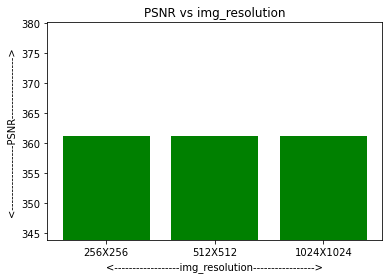

In [7]:
from time import sleep
import heapq
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im 
from termcolor import colored
import math


class HuffmanCoding:
    def __init__(self, path):
        self.path = path
        self.heap = []
        self.codes = {}
        self.reverse_mapping = {}

    class HeapNode:
        def __init__(self, char, freq):
            self.char = char
            self.freq = freq
            self.left = None
            self.right = None

        def __lt__(self, other):
            return self.freq < other.freq

        def __eq__(self, other):
            if(other == None):
                return False
            if(not isinstance(other, HeapNode)):
                return False
            return self.freq == other.freq

# functions for compression:

    def make_frequency_dict(self, o_image):
        frequency = {}
        for character in o_image:
            if not character in frequency:
                frequency[character] = 0
            frequency[character] += 1
        return frequency

    def make_heap(self, frequency):
        for key in frequency:
            node = self.HeapNode(key, frequency[key])
            heapq.heappush(self.heap, node)

    def merge_nodes(self):
        while(len(self.heap)>1):
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            merged = self.HeapNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2

            heapq.heappush(self.heap, merged)


    def make_codes_helper(self, root, current_code):
        if(root == None):
            return

        if(root.char != None):
            self.codes[root.char] = current_code
            self.reverse_mapping[current_code] = root.char
            return

        self.make_codes_helper(root.left, current_code + "0")
        self.make_codes_helper(root.right, current_code + "1")


    def make_codes(self):
        root = heapq.heappop(self.heap)
        current_code = ""
        self.make_codes_helper(root, current_code)


    def get_encoded_o_image(self, o_image):
        encoded_o_image = ""
        for character in o_image:
            encoded_o_image += self.codes[character]
        return encoded_o_image


    def pad_encoded_o_image(self, encoded_o_image):
        extra_padding = 8 - len(encoded_o_image) % 8
        for i in range(extra_padding):
            encoded_o_image += "0"

        padded_info = "{0:08b}".format(extra_padding)
        encoded_o_image = padded_info + encoded_o_image
        return encoded_o_image


    def get_byte_array(self, padded_encoded_o_image):
        if(len(padded_encoded_o_image) % 8 != 0):
            print("Encoded o_image not padded properly")
            exit(0)

        b = bytearray()
        for i in range(0, len(padded_encoded_o_image), 8):
            byte = padded_encoded_o_image[i:i+8]
            b.append(int(byte, 2))
#         print(b)
        return b


    def compress(self):
        filename, file_extension = os.path.splitext(self.path)
        output_path = filename + ".bin"

        with open(output_path, 'wb') as output:
            img = cv2.imread(path,0)
            o_image = img.flatten()

            frequency = self.make_frequency_dict(o_image)
            self.make_heap(frequency)
            self.merge_nodes()
            self.make_codes()
            encoded_o_image = self.get_encoded_o_image(o_image)
            padded_encoded_o_image = self.pad_encoded_o_image(encoded_o_image)
            b = self.get_byte_array(padded_encoded_o_image)
            output.write(bytes(b))

        return output_path

#  functions for decompression: 
    def remove_padding(self, padded_encoded_o_image):
        padded_info = padded_encoded_o_image[:8]
        extra_padding = int(padded_info, 2)

        padded_encoded_o_image = padded_encoded_o_image[8:] 
        encoded_o_image = padded_encoded_o_image[:-1*extra_padding]
        encoded_o_image = str(encoded_o_image)
        return encoded_o_image

    def decode_o_image(self, encoded_o_image):
        current_code = ""
        decoded_o_image = []
        
        for bit in encoded_o_image:
            current_code += bit
            if(current_code in self.reverse_mapping):
                character = self.reverse_mapping[current_code]
                decoded_o_image.append(character)
                current_code = ""
        return decoded_o_image


    def decompress(self, input_path):
        filename, file_extension = os.path.splitext(self.path)
        output_path = filename + "_decompressed" + ".bmp"

        with open(input_path, 'rb') as file, open(output_path, 'wb') as output:
            bit_string = ""

            byte = file.read(1)
            while(len(byte) > 0):
                byte = ord(byte)
                bits = bin(byte)[2:].rjust(8, '0')
                bit_string += bits
                byte = file.read(1)

            encoded_o_image = self.remove_padding(bit_string)
            img = cv2.imread(path,0)
            decompressed_o_image = self.decode_o_image(encoded_o_image) 
            dec_o_image = [i if i is not None else 0 for i in decompressed_o_image]
            out = np.array(dec_o_image)
            out_array = np.reshape(out,img.shape)
            output_img = im.fromarray(out_array.astype(np.uint8))      
            output_img.save(output)
        return output_path
    
PSNR = []
bits_per_pixel = []
compression_ratio = []
for i in range(3):
    input_path = input("Enter image name that is to be compressed:\n")
    input_extension = input('Enter extention of image that is to be compressed:eg.jpg or.png or .jpeg\n')
    print(colored(f"image: {input_path}{input_extension}", 'red', attrs=['bold']))
    img = cv2.imread(input_path + input_extension,0)
    original_input_img = img
    plt.imshow(img,'gray')
    plt.title(f'image {input_path}{input_extension}')
    plt.show()
    print(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i][j] % 10 <= 5):
                img[i][j] = img[i][j] - img[i][j] % 10
            if (img[i][j] % 10 > 5):
                img[i][j] = img[i][j] + (10 - img[i][j] % 10)

    windowsize_r = [4]
    
    for k in windowsize_r:
#         B = img.shape[0]/k
#         no_of_img_blocks.append(B)
        image_all = []
        for r in range(0,img.shape[0], k):
                window = img[r:r+k,:]
                image_all.append(window)
        n = int(img.shape[0]/k)
        input_img_size = 0
        comp_img_size = 0
        for i in range(n):
            output_img = im.fromarray(image_all[i])
            output_img.save(input_path + f"{i}" + ".bmp")
            input_img_size += os.stat(input_path + f"{i}" + ".bmp").st_size
            path = input_path + f"{i}" +  ".bmp"
            h = HuffmanCoding(path)
            output_path = h.compress()
            comp_img_size += os.stat(output_path).st_size
            decom_path = h.decompress(output_path)
            decoded_image = cv2.imread(decom_path,0)
            if i==0:
                img_back = decoded_image
            if (i<n) and i!=0 :
                img_back = np.vstack((img_back,decoded_image))
    plt.imshow(img_back,'gray')
    plt.title(f'decoded_image {input_path}{input_extension}')
    plt.show()
    original_input_img = np.array(original_input_img, dtype = 'uint8')
    img_back = np.array(img_back, dtype = 'uint8')
    psnr = cv2.PSNR(original_input_img, img_back)
    print(psnr)
    PSNR.append(psnr)
    bpp = (comp_img_size)*8 / np.size(original_input_img)
    bits_per_pixel.append(bpp)
    print(bits_per_pixel)
    c = input_img_size/comp_img_size
    compression_ratio.append(c)
    print(compression_ratio)
 
print('\tbits_per_pixel comparision:\n')
x1 = ['256X256','512X512','1024X1024']
y1 = bits_per_pixel
low = min(y1)
high = max(y1)
plt.ylim([3.9,4])
# plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
x_pos = [i for i in range(len(x1))]
plt.bar(x_pos, y1, color='green')
plt.xlabel('<------------------img_resolution----------------->')
plt.ylabel('<------------------bits_per_pixel----------------->')
plt.title('bits_per_pixe vs img_resolution')
plt.xticks(x_pos,x1)
plt.show()


print(compression_ratio)
print('\tcompression_ratio comparision:\n')
x2 = ['256X256','512X512','1024X1024']
y2 = compression_ratio
low = min(y2)
high = max(y2)
plt.ylim([2,4.5])
# plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
x_pos = [i for i in range(len(x2))]
plt.bar(x_pos, y2, color='green')
plt.xlabel('<------------------resolution----------------->')
plt.ylabel('<------------------compression ratio achieved----------------->')
plt.title('compression ratio achieved vs resolution')
plt.xticks(x_pos,x2)
plt.show()

print('\tPSNR_ratio comparision:\n')
x3 = ['256X256','512X512','1024X1024']
y3 = PSNR
low = min(y3)
high = max(y3)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
x_pos = [i for i in range(len(x3))]
plt.bar(x_pos, y3, color='green')
plt.xlabel('<------------------img_resolution----------------->')
plt.ylabel('<------------------PSNR----------------->')
plt.title('PSNR vs img_resolution')
plt.xticks(x_pos,x3)
plt.show()


 